In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.12.0


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import src.relabel_data as rd
import cv2
import numpy as np
from src.create_augement import createAugment
import matplotlib.image as mpimg
from keras.utils import CustomObjectScope
from keras.models import load_model
from PIL import Image, ImageDraw
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# get the new data after filtering and relabeling
x_train, y_train, x_test, y_test = rd.filter_relabel(x_train, y_train, x_test, y_test)

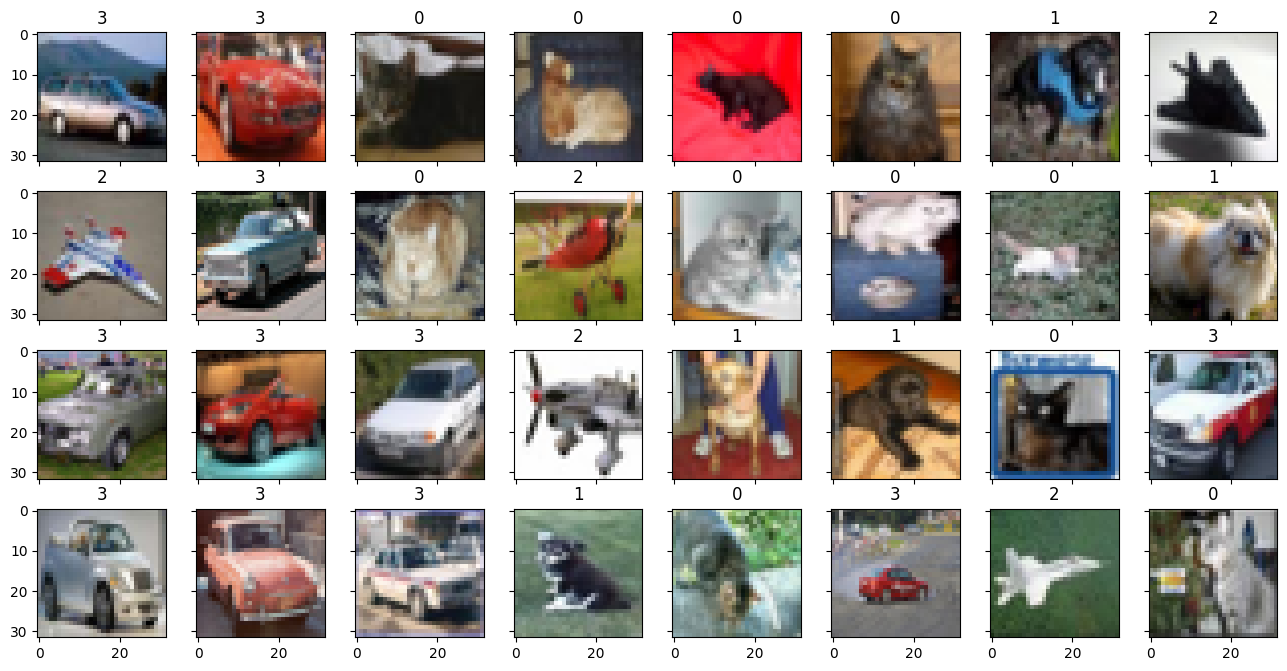

In [4]:
############## plot the images ##############

sample_images = x_train[:32]
sample_labels = y_train[:32]
fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# get the new data after filtering and relabeling
x_train, y_train, x_test, y_test = rd.filter_relabel(x_train, y_train, x_test, y_test)

In [6]:
train_masked = createAugment(x_train, x_train)
test_masked = createAugment(x_test, x_test)

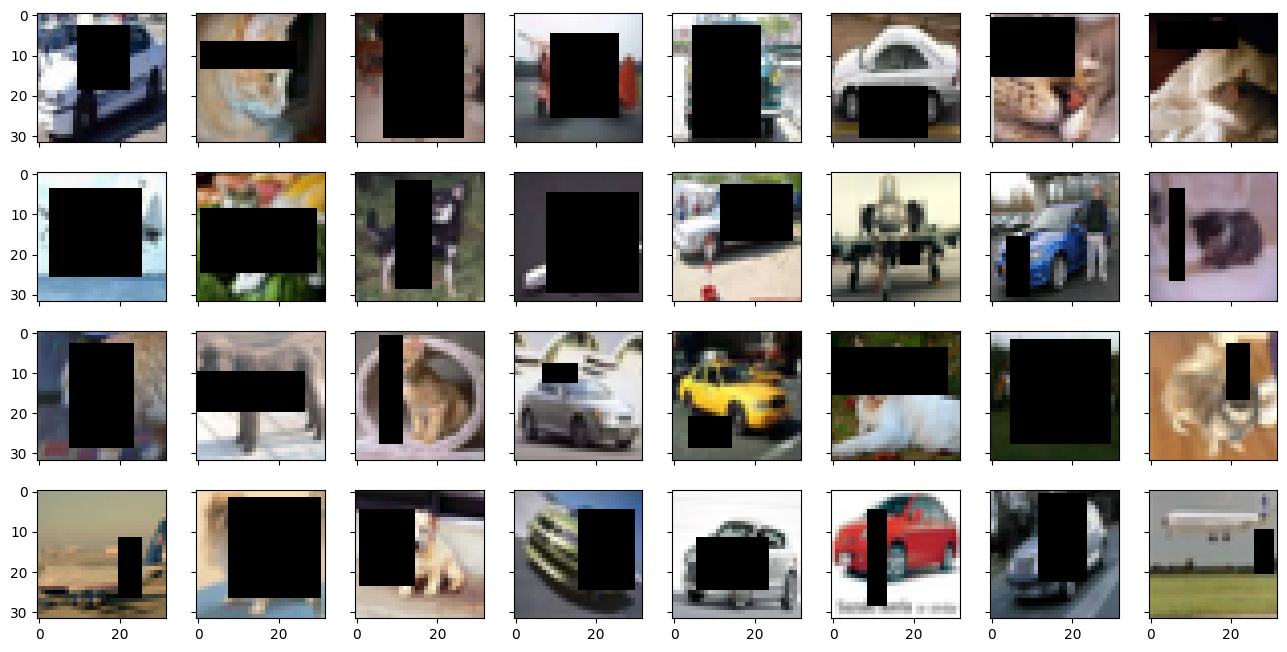

In [7]:
## Examples
random.seed(888)
sample_idx = 100 ## Change this to see different batches

sample_images, sample_labels = train_masked[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [9]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [11]:
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation
from keras.applications.vgg19 import VGG19

def unet_vgg():
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    base_model.trainable = False  # Freeze the base_model

    # Collect encoder layers from VGG19
    conv1 = base_model.get_layer('block1_conv2').output
    conv2 = base_model.get_layer('block2_conv2').output
    conv3 = base_model.get_layer('block3_conv4').output

    # Bottleneck
    conv4 = keras.layers.Conv2D(256, (3, 3), activation=keras.layers.LeakyReLU(), padding='same')(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.Dropout(0.1)(conv4)

    # Decoding / Upsampling
    up1 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv2], axis=3)
    conv5 = keras.layers.Conv2D(128, (3, 3), activation=keras.layers.LeakyReLU(), padding='same')(up1)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.Dropout(0.1)(conv5)

    up2 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv1], axis=3)
    conv6 = keras.layers.Conv2D(64, (3, 3), activation=keras.layers.LeakyReLU(), padding='same')(up2)
    conv6 = keras.layers.BatchNormalization()(conv6)
    conv6 = keras.layers.Dropout(0.1)(conv6)

    # Output
    outputs = keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(conv6)

    return keras.models.Model(inputs=[base_model.input], outputs=[outputs])

keras.backend.clear_session()
model = unet_vgg()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 16, 16, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

In [110]:
# fit the model on the batches generated by datagen.flow()
history = model.fit(train_masked, validation_data=test_masked, 
          epochs=100, 
          steps_per_epoch=len(train_masked), 
          validation_steps=len(test_masked),
          use_multiprocessing=True)

In [ ]:
model.save('transfer_vgg_unet.h5')

In [111]:
# Load the model
with CustomObjectScope({'dice_coef': dice_coef}):
    model = load_model('models/unet_vgg_model.h5')

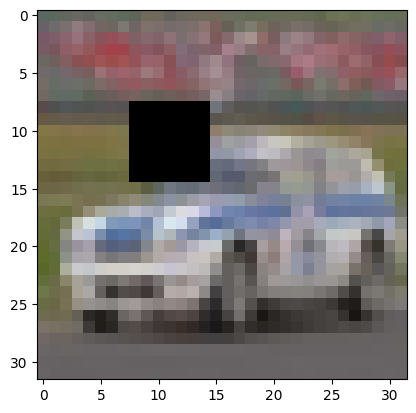

In [112]:
plt.imshow(sample_images[0])

1/1 [==============================] - 0s 151ms/step


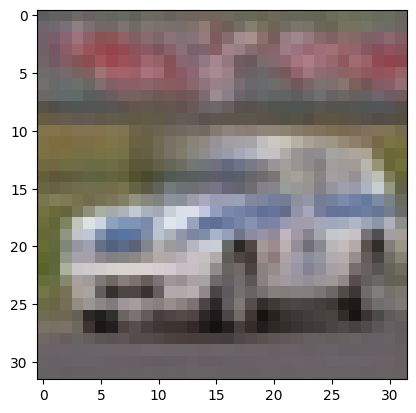

In [113]:
im = sample_images[0]
impainted_image = model.predict(im.reshape((1,)+im.shape))
plt.imshow(impainted_image.reshape(impainted_image.shape[1:]))

1/1 [==============================] - 0s 16ms/step


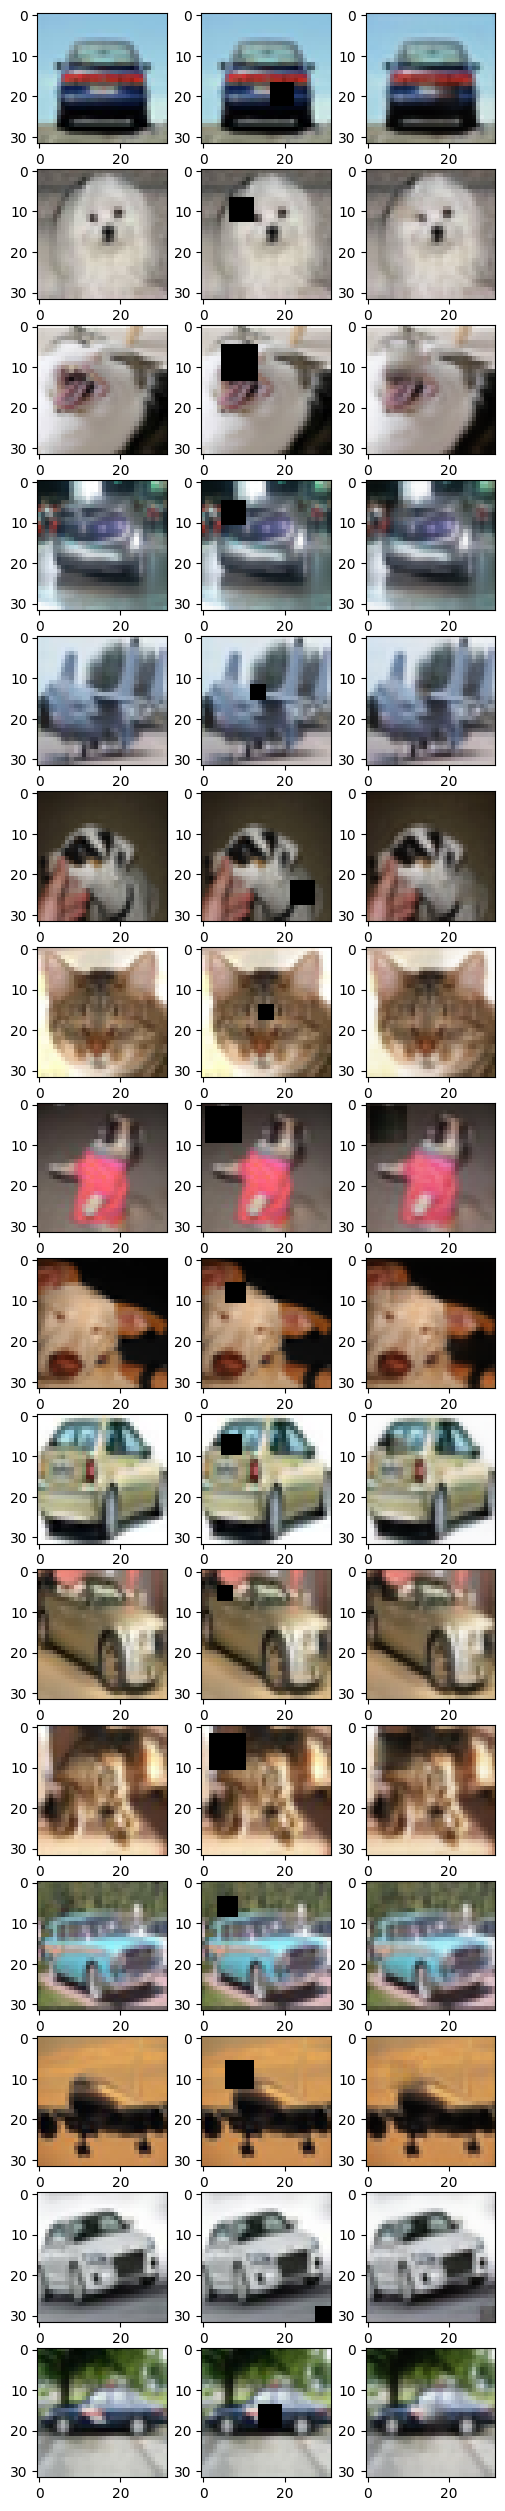

In [114]:
## Examples
rows = 16
sample_idx = np.random.randint(0, len(test_masked), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
  sample_images, sample_labels = train_masked[idx]
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  impainted_image = model.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
  axs[i][0].imshow(sample_labels[img_idx])
  axs[i][1].imshow(sample_images[img_idx])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()

In [116]:
#Load the resized the image for testing
img_resized = Image.open('test_images/test_resized.jpg')
img_resized = np.array(img_resized)

test_dog = img_resized.reshape((1,)+img_resized.shape)

# Add mask to the picture
test_dog_masked = createAugment(test_dog, test_dog)
test_dog_image, test_dog_labels = test_dog_masked[0]

1/1 [==============================] - 0s 23ms/step


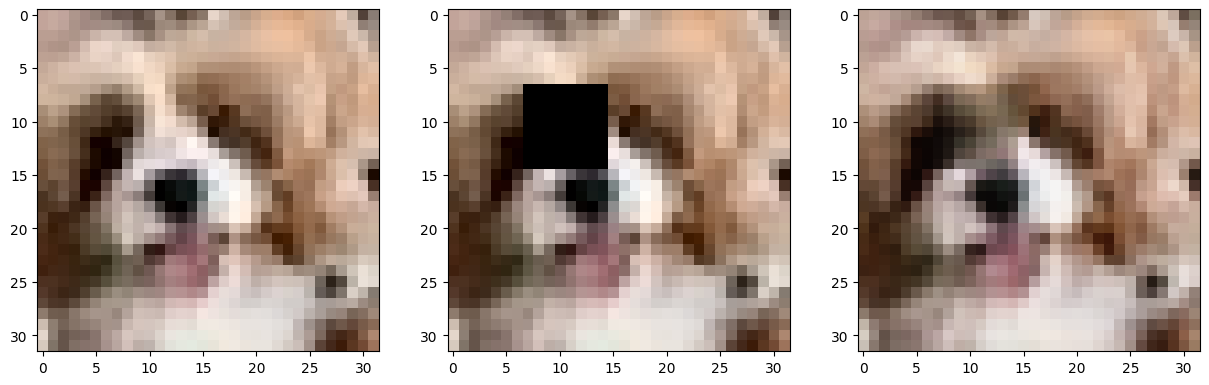

In [117]:
# Fit the model
img_resized_pred = model.predict(test_dog_image[0].reshape((1,)+test_dog_image[0].shape))

# Plot the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(img_resized)
axs[1].imshow(test_dog_image[0])
axs[2].imshow(img_resized_pred.reshape(img_resized_pred.shape[1:]))

plt.show()